In [19]:
# Cell 1: Общее конфигурирование
from agentslab.utils.device import resolve_device
from agentslab.utils.seeding import set_global_seed
from pathlib import Path

device = resolve_device()
print('Device:', device)
 
seed = 42
set_global_seed(seed, deterministic=True)

ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "pendulum"
ENV_ID = "InvertedDoublePendulum-v4"
ENV_ID = "CartPole-v1"

Device: cpu


In [15]:
# DRAFT

from datetime import datetime
from agentslab.utils.checkpointers import CheckpointInfo, save_checkpoint, load_checkpoint

run_name = f"ppo_gym_demo_{datetime.now().strftime('%Y%m%d-%H%M%S')}"


LOGS_ROOT = (ROOT / 'logs').resolve()
CKPT_ROOT = (ROOT / 'checkpoints').resolve()
LOGS_ROOT.mkdir(exist_ok=True)
CKPT_ROOT.mkdir(exist_ok=True)

log_dir = LOGS_ROOT / run_name
ckpt_info = CheckpointInfo(algo='ppo', env_id='InvertedDoublePendulum-v4', run_name='demo', dir_root=str(CKPT_ROOT))
run_ckpt_dir = ckpt_info.make_run_dir()

from agentslab.utils.logger import CSVLogger
from agentslab.utils.curves import plot_training_curves


logger = CSVLogger(str(log_dir))

print('Log dir:', log_dir)
print('Checkpoint dir:', run_ckpt_dir)

Log dir: C:\Users\ordevoir\Documents\GitHub\AgentsLab\logs\ppo_gym_demo_20250821-042035
Checkpoint dir: C:\Users\ordevoir\Documents\GitHub\AgentsLab\checkpoints\ppo_InvertedDoublePendulum-v4_demo_20250821-042035


# Создание среды

In [20]:
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env
from torchrl.envs.utils import check_env_specs

env_cfg = GymEnvConfig(env_id=ENV_ID, render_mode=None, device=device, seed=seed)
env = make_gym_env(env_cfg)
check_env_specs(env)

# from agentslab.utils.specs import print_specs
# print_specs(env)

2025-08-21 04:21:26,721 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора и критика

In [21]:
from agentslab.modules.networks import MLPConfig, build_mlp
from agentslab.modules.policy import build_stochastic_actor
from torchrl.modules import ValueOperator

# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
act_dim = env.action_spec.shape[-1]

mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        out_dim = 2*act_dim,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)

actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)

mlp_cfg.out_dim = act_dim
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])
critic

AttributeError: 'OneHot' object has no attribute 'low'

# Collector

In [ ]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000

collector = SyncDataCollector(
    create_env_fn=env,
    policy=actor,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Loss Function

In [ ]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

gamma = 0.99
lmbda = 0.95

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=critic, average_gae=True
)

clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
entropy_eps = 1e-4

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coeff=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=1.0,
    loss_critic_type="smooth_l1",
)

lr = 3e-4

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=total_frames // frames_per_batch, 
    eta_min=0.0
)


# Logging

In [ ]:
def prepare_logfile(log_dir="logs", name=None, run_name=None, fieldnames=None):
    import os, csv, time
    os.makedirs(log_dir, exist_ok=True)
    ts = time.strftime("%Y%m%d-%H%M%S")
    run_name = run_name or f"run_{ts}"
    if name:
        run_name = name + "_" + run_name
    log_path = os.path.join(log_dir, f"{run_name}.csv")
    fieldnames = fieldnames or ["step","metric","value"]  # дефолт
    with open(log_path, "w", newline="") as f:
        csv.DictWriter(f, fieldnames=fieldnames).writeheader()
    return log_path

def log_row(log_path, fieldnames, row: dict):
    import csv
    with open(log_path, "a", newline="") as f:
        csv.DictWriter(f, fieldnames=fieldnames).writerow(row)

In [ ]:
fieldnames = [
    "batch_idx",
    "frames",
    "reward_mean",
    "reward_init",
    "step_count_max",
    "lr",
    "eval_reward_mean",
    "eval_reward_sum",
    "eval_step_count",
]

log_path = prepare_logfile(fieldnames=fieldnames, name="ppo")
log_path

'logs\\ppo_run_20250821-041745.csv'

## Evaluate

In [ ]:
# from torchrl.envs.utils import ExplorationType, set_exploration_type
# import torch

# from typing import Dict
# @torch.no_grad()
# def eval_policy(env, actor, n_steps: int = 1000) -> Dict[str, float]:
#     """
#     Выполняет детерминированный rollout политики и возвращает метрики.
#     """
#     # На время оценки выключаем стохастику действий
#     actor_was_training = actor.training
#     actor.eval()
#     with set_exploration_type(ExplorationType.DETERMINISTIC):
#         eval_rollout = env.rollout(n_steps, actor)
#         result = {
#             "eval_reward_mean": eval_rollout["next", "reward"].mean().item(),
#             "eval_reward_sum": eval_rollout["next", "reward"].sum().item(),
#             "eval_step_count": eval_rollout["step_count"].max().item(),
#         }
#         del eval_rollout
#     if actor_was_training:
#         actor.train()
#     return result

# Training loop

In [ ]:
from agentslab.runners.evals import eval_policy

eval_policy(env, actor, episodes=50)

eval:   0%|          | 0/50 [00:00<?, ?it/s]

{'return_mean': 69.00655708312988,
 'return_sum': 3450.327854156494,
 'max_episode_lengh': 10,
 'num_episodes': 50}

In [ ]:
from collections import defaultdict
from tqdm.auto import tqdm
from agentslab.runners.evals import eval_policy
from collections import defaultdict

logs = defaultdict(list)
losses = []

pbar = tqdm(total=total_frames, dynamic_ncols=True, leave=True)

max_grad_norm = 1.0
num_epochs = 10
sub_batch_size = 64

# Итерируемся по коллекторам, пока не наберём нужное число шагов
for i, tensordict_data in enumerate(collector):
    # Учимся на партии данных
    for _ in range(num_epochs):
        # Advantage для PPO пересчитываем на каждом проходе
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"] 
                + loss_vals["loss_critic"] 
                + loss_vals["loss_entropy"]
            )
            # Оптимизация
            loss_value.backward()
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
    scheduler.step()            # Шаг LR-планировщика

    # Логируем метрики
    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    logs["lr"].append(optim.param_groups[0]["lr"])

    # Оценка после каждых 2 партий (соответствует условию ниже)
    if (i + 1) % 2 == 0:
        eval_results = eval_policy(env, actor, episodes=5, progress=False)
        # pbar.write не ломает отрисовку прогресс-бара
        pbar.write(f"eval – avg reward: {eval_results["return_mean"]}, max episode lengh: {eval_results["max_episode_lengh"]}")

    # Обновляем описание прогресс-бара
    avg_reward_str = f"avg reward={logs['reward'][-1]: 4.4f}"
    step_count_str = f"max step count: {logs['step_count'][-1]}"
    lr_str = f"lr: {logs['lr'][-1]: 4.4f}"
    
    # корректное число фреймов в пачке
    batch_frames = int(tensordict_data.get(("next", "reward")).numel())
    # аккуратное обновление бара
    inc = min(batch_frames, pbar.total - pbar.n)
    if inc > 0:
        pbar.update(inc)

    pbar.set_description(", ".join([avg_reward_str, step_count_str, lr_str]))

# Гарантированно закрываем бар (важно для корректного вывода в ноутбуках)
pbar.close()


  0%|          | 0/10000 [00:00<?, ?it/s]

eval – avg reward: 103.23108367919922, max episode lengh: 13
eval – avg reward: 142.66787567138672, max episode lengh: 19
eval – avg reward: 131.65445709228516, max episode lengh: 19
eval – avg reward: 161.3946075439453, max episode lengh: 25
eval – avg reward: 202.62415161132813, max episode lengh: 35


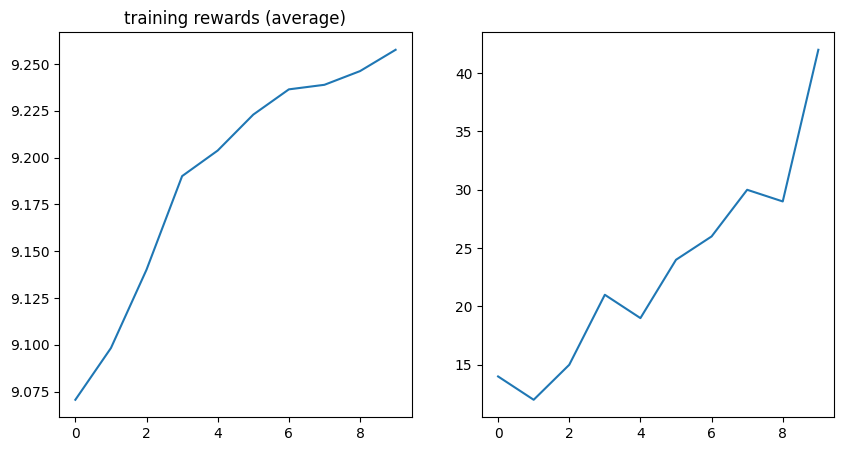

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(1, 2, 2)
plt.plot(logs["step_count"])
plt.show()

In [ ]:
# Cell 3: Конфигурирование trainer и запуск обучения
from agentslab.runners.trainers import PPOTrainer, PPOTrainerConfig
from agentslab.runners.evals import EvalConfig, evaluate_policy

trainer_cfg = PPOTrainerConfig(
    frames_per_batch=1024,
    total_frames=20_480,  # демо; поднимайте до 1e6 для реальных результатов
    sub_batch_size=64,
    num_epochs=10,
    lr=3e-4,
    max_grad_norm=1.0,
    gamma=0.99,
    lam=0.95,
    clip_epsilon=0.2,
    entropy_coef=1e-4,
    seed=seed,
    device=device,
    eval_every=5,
)

def evaluator():
    return evaluate_policy(env, actor, EvalConfig(steps=1000, device=device))

trainer = PPOTrainer(trainer_cfg, env, actor, critic, run_dirs={'ckpt': run_ckpt_dir, 'logs': str(log_dir)}, logger=logger)
trainer.train(evaluator=evaluator)

# Сохранение чекпоинта
ckpt_path = save_checkpoint(run_ckpt_dir, actor, critic, None, None, extra={'iter_done': trainer_cfg.total_frames // trainer_cfg.frames_per_batch})
print('Saved to:', ckpt_path)


ImportError: cannot import name 'EvalConfig' from 'agentslab.runners.evals' (C:\Users\ordevoir\Documents\GitHub\AgentsLab\src\agentslab\runners\evals.py)

In [ ]:
# Cell 4: Конфигурирование и оценка модели
from agentslab.runners.evals import EvalConfig, evaluate_policy
eval_res = evaluate_policy(env, actor, EvalConfig(steps=1000, device=device))
eval_res


In [ ]:
# Cell 5: Построение графиков по логам (matplotlib)
import matplotlib.pyplot as plt
csv_path = (log_dir / 'train_log.csv')
print('CSV:', csv_path)
from agentslab.utils.curves import plot_training_curves
plot_training_curves(str(csv_path))
plt.show()


In [ ]:
# Cell 6: Запуск среды с выбранным render_mode
from torchrl.envs.utils import ExplorationType, set_exploration_type
from tqdm import tqdm

if env_cfg.render_mode is None:
    print('Пересоздаём env с render_mode="human" для визуализации...')
    env_cfg_vis = GymEnvConfig(env_id=env_cfg.env_id, render_mode='human', device=device, seed=seed)
    env_vis = make_gym_env(env_cfg_vis)
else:
    env_vis = env

with torch.no_grad():
    with set_exploration_type(ExplorationType.DETERMINISTIC):
        td = env_vis.reset()
        for _ in tqdm(range(500)):
            td = actor(td)
            td = env_vis.step(td)
            td = td.get('next')

env_vis.close()


In [ ]:
# Cell 7: Восстановление модели из чекпоинта
from agentslab.utils.checkpointers import load_checkpoint
loaded = load_checkpoint(str(Path(run_ckpt_dir) / 'checkpoint.pt'), actor, critic)
print('Loaded extra:', loaded)
